# Speech Prominence Detection

In [1]:
from matplotlib import pyplot as plt
import random
import pickle as pkl
import pandas as pd
import numpy as np
import math
from IPython.display import clear_output

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Conv1D, MaxPooling1D, MaxPooling2D, TimeDistributed, Input, Reshape, concatenate, Conv2D, Concatenate
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


In [3]:
# load data in one line
ger_train = pkl.load(open("../saved/ger_train_syls2.pkl", "rb"))
ger_test = pkl.load(open("../saved/ger_test_syls2.pkl", "rb"))

In [13]:
ger_test.head(20)

,contour,labels
0,"[0.019162689527500977, 0.018757457994703516, 0...",1
1,"[0.018529939196573957, 0.01878130137324399, 0....",0
2,"[0.11961875005931769, 0.121682252123691, 0.127...",0
3,"[0.4515408450270049, 0.4999236321142739, 0.540...",1
4,"[0.01805156620491014, 0.016649114626452348, 0....",1
5,"[0.0221645457951925, 0.020668090583902107, 0.0...",0
6,"[0.017896778569518847, 0.017883121295485412, 0...",1
7,"[0.015459333090689314, 0.016919037359458496, 0...",0
8,"[0.41321841177550306, 0.3831763137349164, 0.36...",1
9,"[0.012285927412519342, 0.011123811428877351, 0...",0


## Stressed and Unstressed Labels

In [16]:
ger_train_labels = np.array(ger_train["labels"])
ger_test_labels = np.array(ger_test["labels"])

ger_train_labels = ger_train_labels
ger_test_labels = ger_test_labels

# count 0s and 1s
zeros_train = np.count_nonzero(ger_train_labels == 0)
ones_train = np.count_nonzero(ger_train_labels == 1)

zeros_test = np.count_nonzero(ger_test_labels == 0)
ones_test = np.count_nonzero(ger_test_labels == 1)

print("Train")
print("0s: ", zeros_train)
print("1s: ", ones_train)
# percentage of 1s
print("Percentage of 1s: ", ones_train / (ones_train + zeros_train))
print("Percentage of 0s: ", zeros_train / (ones_train + zeros_train))
print()
print("Test")
print("0s: ", zeros_test)
print("1s: ", ones_test)

Train
0s:  1656
1s:  1656
Percentage of 1s:  0.5
Percentage of 0s:  0.5

Test
0s:  1467
1s:  1461


## Contour Lengths

In [20]:
# make a list of lengths of all contours
lengths_train = np.array([len(contour) for contour in ger_train["contour"]])
lengths_train.mean()

lengths_test = np.array([len(contour) for contour in ger_test["contour"]])
lengths_test.mean()

print("Train")
print("max length: ", lengths_train.max())
print("mean length: ", lengths_train.mean())
print()
print("Test")
print("max length: ", lengths_test.max())
print("mean length: ", lengths_test.mean())

Train
max length:  138
mean length:  25.21256038647343

Test
max length:  135
mean length:  25.807718579234972


In [22]:
# calculate the max length of all contours
max_length_train = max([len(contour) for contour in ger_train["contour"]])
max_length_test = max([len(contour) for contour in ger_test["contour"]])
max_length = max(max_length_train, max_length_test)

## Padding

In [23]:
# pad all contours to the same length using left padding, right padding, and both side padding
def pad_contours(contours, length, padding="both"):
    padded_contours = []
    for contour in contours:
        if padding == "left":
            padded_contours.append(np.pad(contour, (length-len(contour), 0), 'constant'))
        elif padding == "right":
            padded = np.pad(contour, (0, length-len(contour)), 'constant')
            padded_contours.append(padded)
        elif padding == "both":
            padded = np.pad(contour, (math.floor((length-len(contour))/2), math.ceil((length-len(contour))/2)), 'constant')
            padded_contours.append(padded)
    return np.array(padded_contours)

In [25]:
contours_train_rp = pad_contours(ger_train["contour"], max_length, padding="right")
contours_train_lp = pad_contours(ger_train["contour"], max_length, padding="left")
contours_train_bp = pad_contours(ger_train["contour"], max_length, padding="both")

contours_test_rp = pad_contours(ger_test["contour"], max_length, padding="right")
contours_test_lp = pad_contours(ger_test["contour"], max_length, padding="left")
contours_test_bp = pad_contours(ger_test["contour"], max_length, padding="both")

In [26]:
contours_train_rp_df = pd.DataFrame(contours_train_rp)
contours_train_lp_df = pd.DataFrame(contours_train_lp)
contours_train_bp_df = pd.DataFrame(contours_train_bp)

right


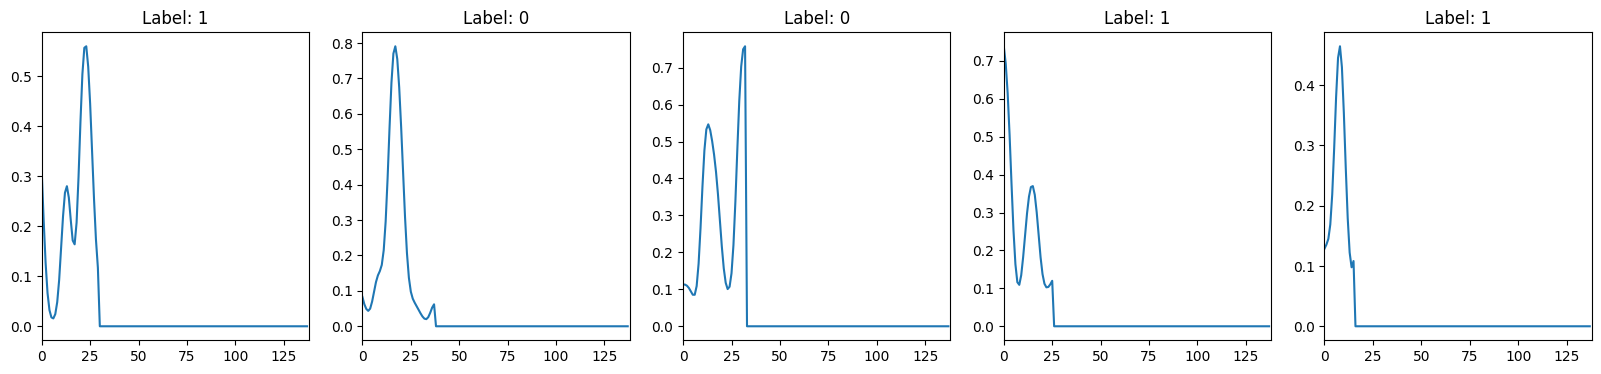

left


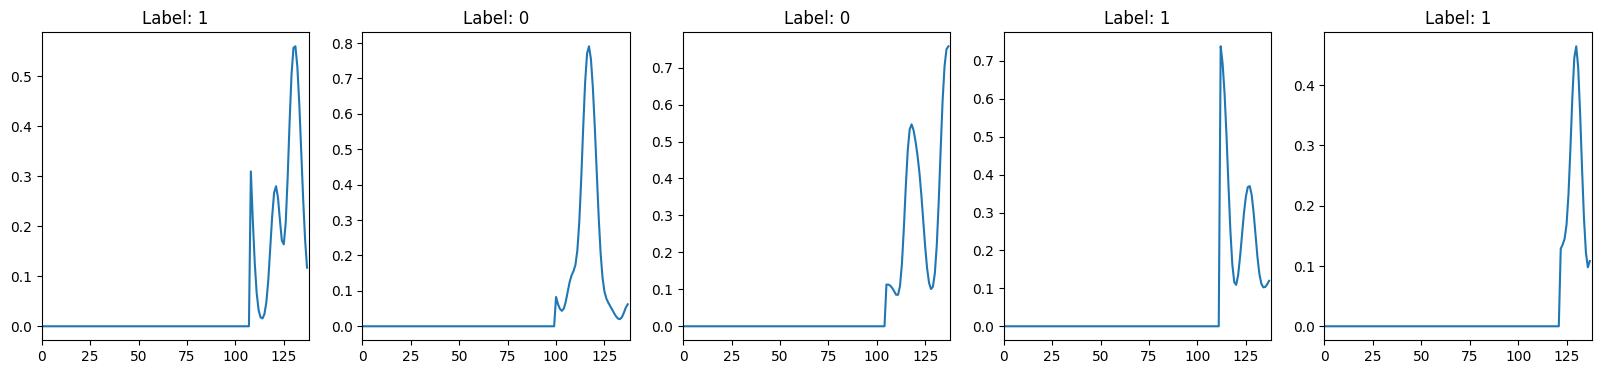

both


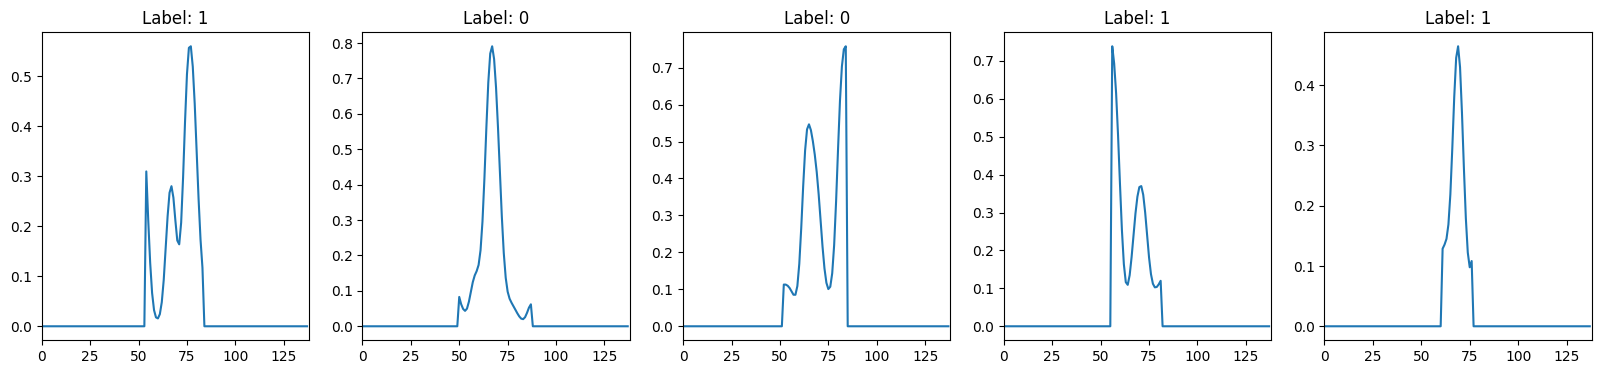

In [27]:
# visualize the padded contours side by side with subplots
def plot_contours(contours, labels, length, padding="both"):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    print(padding)

    for i in range(5):
        r = random.randint(0, len(contours)-1)
        z = i + 100
        axs[i].plot(contours[z])
        axs[i].set_title("Label: " + str(labels[z]))


        if padding == "left":
            axs[i].set_xlim(0, length)

        elif padding == "right":
            axs[i].set_xlim(0, length)

        elif padding == "both":
            axs[i].set_xlim(0, length)
    plt.show()

plot_contours(contours_train_rp, ger_train_labels, max_length, padding="right")
plot_contours(contours_train_lp, ger_train_labels, max_length, padding="left")
plot_contours(contours_train_bp, ger_train_labels, max_length, padding="both")

## Model

In [28]:
model = Sequential()
model.add(Dense(64, input_dim=max_length, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                8896      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 512)               131584    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 2

In [30]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(contours_train_rp, ger_train_labels, batch_size=8, epochs=40, validation_split=0.1)

Epoch 1/40
373/373 [==============================] - 4s 6ms/step - loss: 0.6875 - accuracy: 0.5520 - val_loss: 0.6765 - val_accuracy: 0.5843
Epoch 2/40
373/373 [==============================] - 2s 5ms/step - loss: 0.6810 - accuracy: 0.5725 - val_loss: 0.6626 - val_accuracy: 0.5873
Epoch 3/40
373/373 [==============================] - 2s 5ms/step - loss: 0.6748 - accuracy: 0.5916 - val_loss: 0.6631 - val_accuracy: 0.5693
Epoch 4/40
373/373 [==============================] - 2s 5ms/step - loss: 0.6726 - accuracy: 0.6020 - val_loss: 0.6680 - val_accuracy: 0.5753
Epoch 5/40
373/373 [==============================] - 2s 5ms/step - loss: 0.6695 - accuracy: 0.5943 - val_loss: 0.6645 - val_accuracy: 0.5873
Epoch 6/40
373/373 [==============================] - 2s 5ms/step - loss: 0.6658 - accuracy: 0.5997 - val_loss: 0.6670 - val_accuracy: 0.5663
Epoch 7/40
373/373 [==============================] - 2s 5ms/step - loss: 0.6677 - accuracy: 0.6003 - val_loss: 0.6670 - val_accuracy: 0.5964
Epoch 

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def results(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred = np.round(y_pred)
    y_pred = y_pred.astype(int)
    y_pred = y_pred.flatten()

    y_test = np.array(y_test)
    y_test = y_test.astype(int)

    # in percentage
    print("Accuracy: ", np.sum(y_pred == y_test)/len(y_test)*100, "%")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='g')

    return y_pred

92/92 [==============================] - 0s 3ms/step
Accuracy:  59.49453551912568 %


array([1, 0, 0, ..., 1, 0, 0])

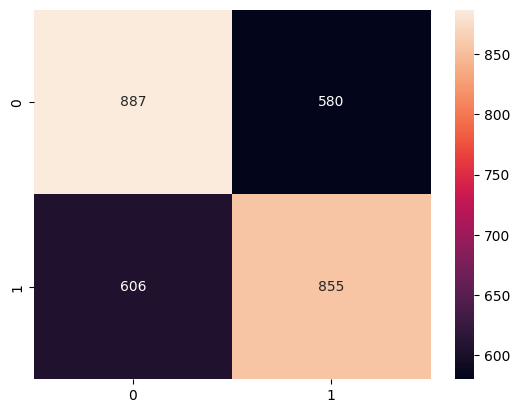

In [32]:
results(model, contours_test_rp, ger_test_labels)

# Combine the Datasets

In [33]:
# merge the train and test sets for german
contours_merged = np.concatenate((contours_train_rp, contours_test_rp), axis=0)
labels_merged = np.concatenate((ger_train_labels, ger_test_labels), axis=0)

print(contours_merged.shape)
print(labels_merged.shape)

(6240, 138)
(6240,)


In [34]:
# remove the contours whose max value is 0
contours_merged_nonzero = contours_merged[contours_merged.max(axis=1) != 0]
labels_merged_nonzero = labels_merged[contours_merged.max(axis=1) != 0]

print(contours_merged_nonzero.shape)
print(labels_merged_nonzero.shape)  

(6059, 138)
(6059,)


In [35]:
contours_merged_normalized = contours_merged_nonzero / contours_merged_nonzero.max(axis=1)[:,None]
contours_merged_nonzero.shape

(6059, 138)

In [36]:
contours_merged_normalized

array([[0.97150155, 0.94850666, 0.93340757, ..., 0.        , 0.        ,
        0.        ],
       [0.94444678, 0.75349733, 0.6220646 , ..., 0.        , 0.        ,
        0.        ],
       [0.46069308, 0.51128889, 0.53805957, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.68841627, 0.41400728, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.95066538, 0.91192892, ..., 0.        , 0.        ,
        0.        ],
       [0.66881956, 0.69185361, 0.73640195, ..., 0.        , 0.        ,
        0.        ]])

In [37]:
# do a train test split
contours_train_merged, contours_test_merged, labels_train_merged, labels_test_merged = train_test_split(contours_merged_normalized, labels_merged_nonzero, test_size=0.2, random_state=42)

In [38]:
print(contours_train_merged.shape)
print(contours_test_merged.shape)

# count 0s and 1s in the train and test sets
print("Train")
print("0s: ", np.sum(labels_train_merged == 0))
print("1s: ", np.sum(labels_train_merged == 1))

print()
print("Test")
print("0s: ", np.sum(labels_test_merged == 0))
print("1s: ", np.sum(labels_test_merged == 1))

(4847, 138)
(1212, 138)
Train
0s:  2409
1s:  2438

Test
0s:  613
1s:  599


In [39]:
# class weights
class_weights = compute_class_weight("balanced", classes=[0, 1], y=labels_train_merged)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:")
for label, weight in class_weights_dict.items():
    print(f"{label}:    {weight:.2f}")

Class weights:
0:    1.01
1:    0.99


In [40]:
# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [41]:
# Define the model
model = Sequential()
model.add(Dense(64, input_dim=max_length, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                8896      
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dense_8 (Dense)             (None, 256)               33024     
                                                                 
 dense_9 (Dense)             (None, 512)               131584    
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dense_12 (Dense)            (None, 64)               

In [42]:
# compile with adam optimizer with learning rate 0.0001
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [43]:
model.fit(
    contours_train_merged, labels_train_merged,
    batch_size=2, epochs=100, validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
1939/1939 [==============================] - 9s 4ms/step - loss: 0.6872 - accuracy: 0.5424 - val_loss: 0.6739 - val_accuracy: 0.5742
Epoch 2/100
1939/1939 [==============================] - 7s 4ms/step - loss: 0.6737 - accuracy: 0.5672 - val_loss: 0.6665 - val_accuracy: 0.5814
Epoch 3/100
1939/1939 [==============================] - 8s 4ms/step - loss: 0.6648 - accuracy: 0.5822 - val_loss: 0.6701 - val_accuracy: 0.5866
Epoch 4/100
1939/1939 [==============================] - 8s 4ms/step - loss: 0.6626 - accuracy: 0.5881 - val_loss: 0.6578 - val_accuracy: 0.6041
Epoch 5/100
1939/1939 [==============================] - 8s 4ms/step - loss: 0.6584 - accuracy: 0.6018 - val_loss: 0.6643 - val_accuracy: 0.5845
Epoch 6/100
1939/1939 [==============================] - 7s 4ms/step - loss: 0.6541 - accuracy: 0.6059 - val_loss: 0.6623 - val_accuracy: 0.5804
Epoch 7/100
1939/1939 [==============================] - 7s 4ms/step - loss: 0.6487 - accuracy: 0.6149 - val_loss: 0.6614 - val_ac

38/38 [==============================] - 0s 2ms/step
Accuracy:  56.188118811881196 %


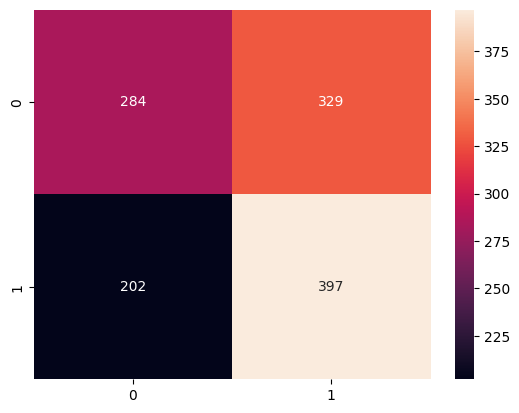

In [44]:
ans = results(model, contours_test_merged, labels_test_merged)

In [45]:
ans

array([1, 1, 0, ..., 1, 0, 1])

In [46]:
max_length

138

# Augmentation

In [47]:
ger_train

,contour,labels
0,"[0.03177828067373946, 0.03102610675462413, 0.0...",1
1,[],0
2,"[0.29295377456846683, 0.23372400800342857, 0.1...",0
3,"[0.3558331626873156, 0.39491268819019043, 0.41...",1
4,"[0.025010218876618886, 0.024972723808391342, 0...",1
...,...,...
3307,"[0.2383755903657169, 0.257137209119076, 0.2676...",0
3308,"[0.036857771050576686, 0.03435310170471866, 0....",1
3309,"[0.022904583654710153, 0.02171224026991739, 0....",0
3310,"[0.00959550945037777, 0.009706386715890893, 0....",1


In [48]:
ger_train.shape

(3312, 2)

In [51]:
# augment the data
def augment(contours, labels, length):
    contours_aug = []
    labels_aug = []

    for i, contour in enumerate(contours):
        label = labels[i]

        for p in range(0, length - len(contour), 10):
            padded_contour = np.pad(contour, (p, length-len(contour) - p), 'constant')
            contours_aug.append(padded_contour)
            labels_aug.append(label)
        clear_output(wait=True)
        
        
        # print progress
        if i % 100 == 0:
            print(f"Augmenting contour {i} out of {len(contours)}")
            print("Percentage: ", i/len(contours)*100, "%")

        if i == len(contours) - 1:
            print("Done")
            return contours_aug, labels_aug

In [52]:
# get augmented data
contours_aug, labels_aug = augment(ger_train["contour"], ger_train["labels"], max_length)
print(contours_aug)

Done


KeyboardInterrupt: 

In [58]:
# convert to numpy arrays
contours_aug = np.array(contours_aug)
labels_aug = np.array(labels_aug)

In [59]:
contours_aug.shape

(38818, 138)

In [60]:
zeros_aug = np.count_nonzero(labels_aug == 0)
ones_aug = np.count_nonzero(labels_aug == 1)

print(zeros_aug)
print(ones_aug)

19820
18998


In [56]:
N = 160000
indices_to_drop = np.where(labels_aug == 1)[0][:N]

filtered_contours_aug = np.delete(contours_aug, indices_to_drop, axis=0)
filtered_labels_aug = np.delete(labels_aug, indices_to_drop)

In [57]:
zeros_aug = np.count_nonzero(labels_aug == 0)
ones_aug = np.count_nonzero(filtered_labels_aug == 1)

print(zeros_aug)
print(ones_aug)

19820
0


In [61]:
# visualize the padded contours side by side with subplots
def plot_contours(contours, labels, length, padding="both"):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    print(padding)

    for i in range(5):
        r = random.randint(0, len(contours)-1)
        z = i * 10
        axs[i].plot(contours[z])
        axs[i].set_title("Label: " + str(labels[z]))


        if padding == "left":
            axs[i].set_xlim(0, length)

        elif padding == "right":
            axs[i].set_xlim(0, length)

        elif padding == "both":
            axs[i].set_xlim(0, length)
    plt.show()

both


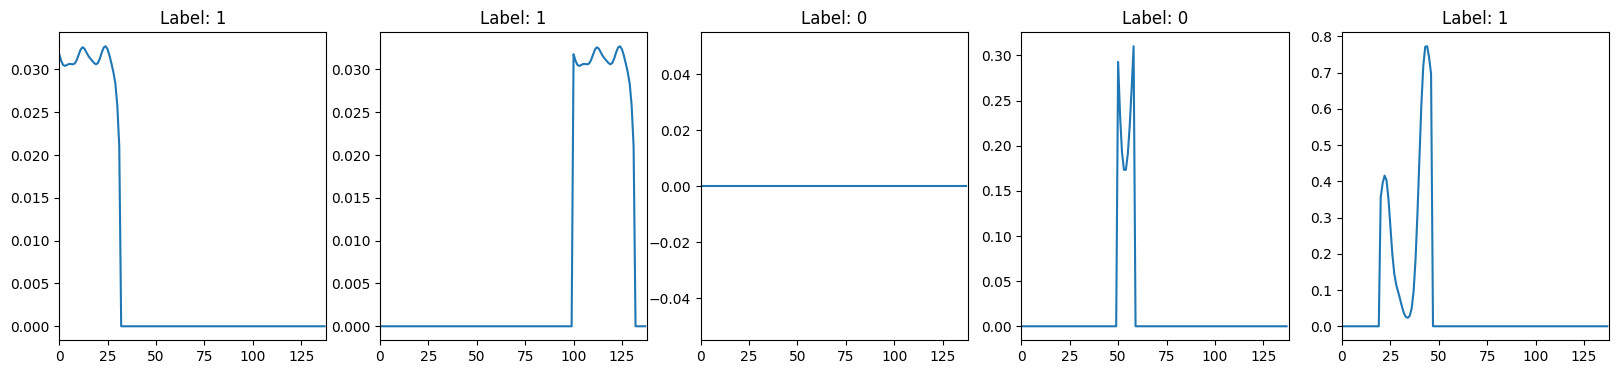

In [62]:
plot_contours(contours_aug, labels_aug, max_length)

In [63]:
print(filtered_contours_aug.shape)
print(filtered_labels_aug.shape)

(19820, 138)
(19820,)


# Augmented Contours Skewed

In [67]:
# Define the input shape
input_shape = (max_length,)

# Define the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=input_shape))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 128)               17792     
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 26,113
Trainable params: 26,113
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
model.fit(contours_aug, labels_aug, epochs=10, batch_size=8, validation_split=0.2)

Epoch 1/10
3882/3882 [==============================] - 8s 2ms/step - loss: 0.6784 - accuracy: 0.5735 - val_loss: 0.6698 - val_accuracy: 0.5962
Epoch 2/10
3882/3882 [==============================] - 8s 2ms/step - loss: 0.6711 - accuracy: 0.5878 - val_loss: 0.6659 - val_accuracy: 0.5966
Epoch 3/10
3882/3882 [==============================] - 8s 2ms/step - loss: 0.6684 - accuracy: 0.5917 - val_loss: 0.6647 - val_accuracy: 0.5970
Epoch 4/10
3882/3882 [==============================] - 7s 2ms/step - loss: 0.6661 - accuracy: 0.5962 - val_loss: 0.6643 - val_accuracy: 0.5997
Epoch 5/10
3882/3882 [==============================] - 8s 2ms/step - loss: 0.6642 - accuracy: 0.6002 - val_loss: 0.6652 - val_accuracy: 0.5929
Epoch 6/10
3882/3882 [==============================] - 9s 2ms/step - loss: 0.6626 - accuracy: 0.6027 - val_loss: 0.6624 - val_accuracy: 0.5939
Epoch 7/10
3882/3882 [==============================] - 8s 2ms/step - loss: 0.6608 - accuracy: 0.6034 - val_loss: 0.6647 - val_accuracy:

1214/1214 [==============================] - 2s 1ms/step
Accuracy:  60.848060178267815 %


array([0, 0, 0, ..., 0, 0, 0])

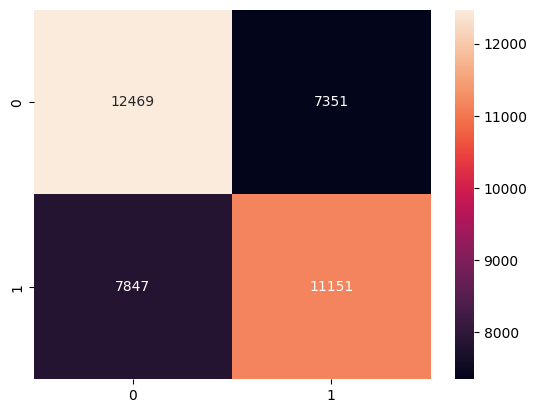

In [70]:
results(model, contours_aug, labels_aug)

# Augmented Contours Balanced

In [84]:
# Define the input shape
input_shape = (285,)
 
# Define the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=input_shape))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 128)               36608     
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 1)                 65        
                                                                 
Total params: 44,929
Trainable params: 44,929
Non-trainable params: 0
_________________________________________________________________


In [85]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [87]:
model.fit(filtered_contours_aug, filtered_labels_aug, epochs=10, batch_size=8, validation_split=0.2)

Epoch 1/10
16220/16220 [==============================] - 53s 3ms/step - loss: 0.5505 - accuracy: 0.7214 - val_loss: 0.6469 - val_accuracy: 0.6703
Epoch 2/10
16220/16220 [==============================] - 43s 3ms/step - loss: 0.5128 - accuracy: 0.7547 - val_loss: 0.6433 - val_accuracy: 0.6703
Epoch 3/10
16220/16220 [==============================] - 45s 3ms/step - loss: 0.5014 - accuracy: 0.7601 - val_loss: 0.6408 - val_accuracy: 0.6724
Epoch 4/10
16220/16220 [==============================] - 43s 3ms/step - loss: 0.4937 - accuracy: 0.7647 - val_loss: 0.6812 - val_accuracy: 0.6579
Epoch 5/10
16220/16220 [==============================] - 43s 3ms/step - loss: 0.4872 - accuracy: 0.7676 - val_loss: 0.6627 - val_accuracy: 0.6622
Epoch 6/10
16220/16220 [==============================] - 44s 3ms/step - loss: 0.4812 - accuracy: 0.7704 - val_loss: 0.6576 - val_accuracy: 0.6625
Epoch 7/10
16220/16220 [==============================] - 43s 3ms/step - loss: 0.4764 - accuracy: 0.7734 - val_loss: 0

10069/10069 [==============================] - 18s 2ms/step
Accuracy:  69.64921972960558 %


array([1, 1, 1, ..., 0, 0, 0])

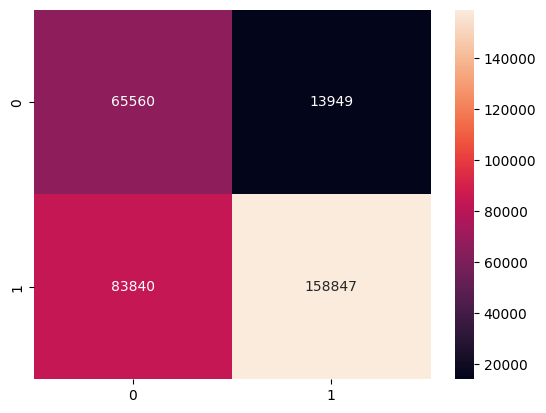

In [88]:
results(model, contours_aug, labels_aug)    

# Augmented Contours Balanced - More Layers

In [71]:
# Define the input shape
input_shape = (max_length,)

# Define the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=input_shape))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))  # New layer
model.add(Dense(16, activation='relu'))  # New layer
model.add(Dense(8, activation='relu'))   # New layer
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               17792     
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 16)                528       
                                                                 
 dense_24 (Dense)            (None, 8)                 136       
                                                                 
 dense_25 (Dense)            (None, 1)                 9         
                                                                 
Total params: 28,801
Trainable params: 28,801
Non-trai

In [72]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [75]:
model.fit(contours_aug, labels_aug, epochs=20, batch_size=4, validation_split=0.2)

Epoch 1/20
7764/7764 [==============================] - 15s 2ms/step - loss: 0.6498 - accuracy: 0.6138 - val_loss: 0.6586 - val_accuracy: 0.5917
Epoch 2/20
7764/7764 [==============================] - 15s 2ms/step - loss: 0.6478 - accuracy: 0.6145 - val_loss: 0.6604 - val_accuracy: 0.5878
Epoch 3/20
7764/7764 [==============================] - 15s 2ms/step - loss: 0.6463 - accuracy: 0.6185 - val_loss: 0.6694 - val_accuracy: 0.5994
Epoch 4/20
7764/7764 [==============================] - 15s 2ms/step - loss: 0.6446 - accuracy: 0.6173 - val_loss: 0.6614 - val_accuracy: 0.5962
Epoch 5/20
7764/7764 [==============================] - 15s 2ms/step - loss: 0.6427 - accuracy: 0.6230 - val_loss: 0.6603 - val_accuracy: 0.6001
Epoch 6/20
7764/7764 [==============================] - 15s 2ms/step - loss: 0.6393 - accuracy: 0.6266 - val_loss: 0.6644 - val_accuracy: 0.5943
Epoch 7/20
7764/7764 [==============================] - 15s 2ms/step - loss: 0.6375 - accuracy: 0.6250 - val_loss: 0.6638 - val_ac

1214/1214 [==============================] - 2s 1ms/step
Accuracy:  64.9492503477768 %


array([1, 1, 1, ..., 1, 1, 0])

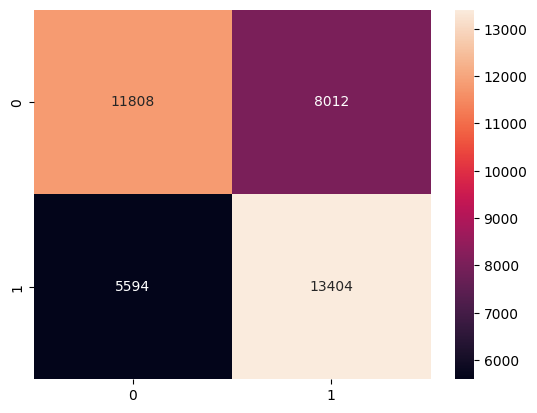

In [76]:
results(model, contours_aug, labels_aug)  

# Merging CNN and DNN

In [48]:
# Define the input shapes
input_shape1 = (138, 1)
input_shape2 = (1,)

# Define the input layers
input1 = Input(shape=input_shape1)
input2 = Input(shape=input_shape2)


In [49]:
# Define the LSTM layer
lstm_output = LSTM(128)(input1)

# Concatenate the LSTM output and the length input
concatenated = Concatenate()([lstm_output, input2])

# reduce the dimension, 128 is too high (32, 16, ...)
# dropouts

In [50]:
# Define the dense layers
dense1 = Dense(64, activation='relu')(concatenated)
dense2 = Dense(1, activation='sigmoid')(dense1)

In [51]:
# Define the model with two inputs
model = Model(inputs=[input1, input2], outputs=dense2)

In [52]:
# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 138, 1)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          66560       ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 129)          0           ['lstm[0][0]',                   
                                                                  'input_2[0][0]']            

In [53]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [55]:
ger_train_contours = ger_train["chunks"]
type(ger_train_contours)
ger_train_contours.shape

(12195,)

In [56]:
ger_train_contours = np.array(ger_train_contours)
type(ger_train_contours)

numpy.ndarray

In [57]:
ger_train_contours
ger_train_2d = np.stack(contours_train_rp)

In [58]:
# Convert the input data to TensorFlow tensors
X_tensor = tf.convert_to_tensor(ger_train_2d, dtype=tf.float32)
y_tensor = tf.convert_to_tensor(ger_train_labels, dtype=tf.float32)

In [59]:
model.fit([ger_train_2d, lengths_train], ger_train_labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


ValueError: in user code:

    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 138, 1), found shape=(None, 285)


# Duration - Method 1

In [ ]:
# append length of contours to the end of each contour
def append_length_end(contours):
    appended_contours = []
    for contour in contours:
        appended_contours.append(np.append(contour, len(contour)))
    return np.array(appended_contours)

# append length of contours to the beginning of each contour
def append_length_start(contours):
    appended_contours = []
    for contour in contours:
        appended_contours.append(np.append(len(contour), contour))
    return np.array(appended_contours)

contours_train_rp_duration = append_length_end(contours_train_rp)
contours_test_rp_duration = append_length_end(contours_test_rp)
contours_train_lp_duration = append_length_start(contours_train_lp)
contours_test_lp_duration = append_length_start(contours_test_lp)

In [ ]:
contours_train_rp_duration.shape

(12195, 286)

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=max_length + 1, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(contours_train_rp_duration, ger_train["labels"], batch_size=16, epochs=50, validation_split=0.2)

Epoch 1/50
610/610 [==============================] - 4s 6ms/step - loss: 0.6109 - accuracy: 0.7487 - val_loss: 0.5440 - val_accuracy: 0.7552
Epoch 2/50
610/610 [==============================] - 3s 5ms/step - loss: 0.5326 - accuracy: 0.7556 - val_loss: 0.5375 - val_accuracy: 0.7552
Epoch 3/50
610/610 [==============================] - 3s 5ms/step - loss: 0.5221 - accuracy: 0.7558 - val_loss: 0.5103 - val_accuracy: 0.7552
Epoch 4/50
610/610 [==============================] - 3s 5ms/step - loss: 0.5087 - accuracy: 0.7558 - val_loss: 0.5185 - val_accuracy: 0.7552
Epoch 5/50
610/610 [==============================] - 3s 5ms/step - loss: 0.5050 - accuracy: 0.7558 - val_loss: 0.5186 - val_accuracy: 0.7552
Epoch 6/50
610/610 [==============================] - 3s 5ms/step - loss: 0.4981 - accuracy: 0.7558 - val_loss: 0.4914 - val_accuracy: 0.7552
Epoch 7/50
610/610 [==============================] - 3s 5ms/step - loss: 0.4955 - accuracy: 0.7556 - val_loss: 0.5131 - val_accuracy: 0.7552
Epoch 

331/331 [==============================] - 1s 2ms/step
Accuracy:  80.19465180005669 %


array([1, 0, 1, ..., 1, 0, 1])

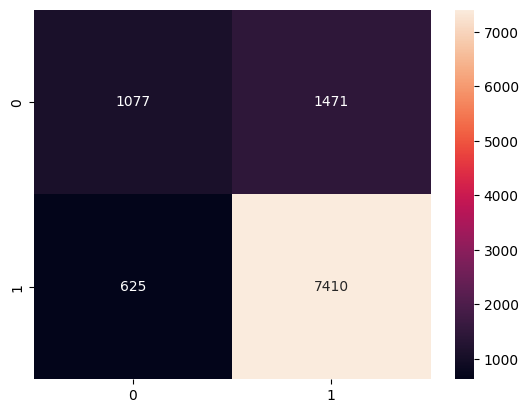

In [ ]:
results(model, contours_test_rp_duration, ger_test["labels"])

In [ ]:
# predict on test set
pred = model.predict(contours_test_rp_duration)
threshold = 0.5
pred[pred >= threshold] = 1
pred[pred < threshold] = 0
pred = pred.reshape(-1)

137/137 [==============================] - 0s 2ms/step


In [ ]:
# calculate accuracy
num_correct = np.count_nonzero(ger_test_labels == pred)
num_wrong = len(ger_test_labels) - num_correct
accuracy = num_correct / len(ger_test_labels)
num_1as0 = np.count_nonzero((ger_test_labels == 1) & (pred == 0))
num_1 = np.count_nonzero(ger_test_labels == 1)
num_0as1 = np.count_nonzero((ger_test_labels == 0) & (pred == 1))
num_0 = np.count_nonzero(ger_test_labels == 0)
perc0as1 = (num_0as1 / num_0 )* 100

In [ ]:
# display results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Num 1 as 0: {num_1as0} out of {num_1}")
print(f"Num 0 as 1: {num_0as1} out of {num_0}")
print(f"0 as 1 percentage: {perc0as1:.2f}%")

Accuracy: 62.93%
Num 1 as 0: 1023 out of 1919
Num 0 as 1: 598 out of 2454
0 as 1 percentage: 24.37%


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(contours_train_lp_duration, train_labels, batch_size=16, epochs=50, validation_split=0.2)

Epoch 1/50
254/254 [==============================] - 2s 5ms/step - loss: 0.6951 - accuracy: 0.5505 - val_loss: 0.6902 - val_accuracy: 0.5621
Epoch 2/50
254/254 [==============================] - 1s 5ms/step - loss: 0.6882 - accuracy: 0.5514 - val_loss: 0.6822 - val_accuracy: 0.5621
Epoch 3/50
254/254 [==============================] - 1s 5ms/step - loss: 0.6819 - accuracy: 0.5662 - val_loss: 0.6634 - val_accuracy: 0.6124
Epoch 4/50
254/254 [==============================] - 1s 5ms/step - loss: 0.6719 - accuracy: 0.5951 - val_loss: 0.7431 - val_accuracy: 0.5759
Epoch 5/50
254/254 [==============================] - 1s 5ms/step - loss: 0.6693 - accuracy: 0.6040 - val_loss: 0.6585 - val_accuracy: 0.6262
Epoch 6/50
254/254 [==============================] - 1s 5ms/step - loss: 0.6662 - accuracy: 0.6077 - val_loss: 0.6631 - val_accuracy: 0.6183
Epoch 7/50
254/254 [==============================] - 1s 5ms/step - loss: 0.6625 - accuracy: 0.6190 - val_loss: 0.6533 - val_accuracy: 0.6410
Epoch 

In [ ]:
# predict on test set
pred = model.predict(contours_test_lp_duration)
threshold = 0.5
pred[pred >= threshold] = 1
pred[pred < threshold] = 0
pred = pred.reshape(-1)

137/137 [==============================] - 0s 2ms/step


In [ ]:
# calculate accuracy
num_correct = np.count_nonzero(ger_test_labels == pred)
num_wrong = len(ger_test_labels) - num_correct
accuracy = num_correct / len(ger_test_labels)
num_1as0 = np.count_nonzero((ger_test_labels == 1) & (pred == 0))
num_1 = np.count_nonzero(ger_test_labels == 1)
num_0as1 = np.count_nonzero((ger_test_labels == 0) & (pred == 1))
num_0 = np.count_nonzero(ger_test_labels == 0)
perc0as1 = (num_0as1 / num_0 )* 100

In [ ]:
# display results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Num 1 as 0: {num_1as0} out of {num_1}")
print(f"Num 0 as 1: {num_0as1} out of {num_0}")
print(f"0 as 1 percentage: {perc0as1:.2f}%")

Accuracy: 63.11%
Num 1 as 0: 800 out of 1919
Num 0 as 1: 813 out of 2454
0 as 1 percentage: 33.13%


In [ ]:
contours_test_lp_duration.shape

(4373, 139)

# Duration - Method 2

In [ ]:
# Define input shapes
contour_shape = (138, )
duration_shape = (1, )

# Define inputs
contour_input = Input(shape=contour_shape, name='contour_input')
duration_input = Input(shape=duration_shape, name='duration_input')

In [ ]:
# Reshape contour input to 3D tensor
contour_3d = Reshape(target_shape=(contour_shape[0], 1))(contour_input)

# Define RNN layer
rnn_layer = LSTM(units=64, name='rnn')(contour_3d)

In [ ]:
# Concatenate duration and RNN layer outputs
concat_layer = concatenate([rnn_layer, duration_input])

In [ ]:
# Define stress label prediction layer
stress_pred = Dense(units=1, activation='sigmoid', name='stress')(concat_layer)

In [ ]:
# Define model
model = Model(inputs=[contour_input, duration_input], outputs=stress_pred)
model.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 contour_input (InputLayer)     [(None, 138)]        0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 138, 1)       0           ['contour_input[0][0]']          
                                                                                                  
 rnn (LSTM)                     (None, 64)           16896       ['reshape_1[0][0]']              
                                                                                                  
 duration_input (InputLayer)    [(None, 1)]          0           []                               
                                                                                              

In [ ]:
# Train model
model.fit(x=[contours_train_rp, max_length], y=ger_train['labels'], epochs=50, batch_size=32)

Epoch 1/50
159/159 [==============================] - 6s 39ms/step - loss: 0.6721
Epoch 2/50
159/159 [==============================] - 6s 40ms/step - loss: 0.6719
Epoch 3/50
159/159 [==============================] - 6s 36ms/step - loss: 0.6712
Epoch 4/50
159/159 [==============================] - 6s 36ms/step - loss: 0.6719
Epoch 5/50
159/159 [==============================] - 6s 36ms/step - loss: 0.6720
Epoch 6/50
159/159 [==============================] - 6s 35ms/step - loss: 0.6727
Epoch 7/50
159/159 [==============================] - 6s 36ms/step - loss: 0.6715
Epoch 8/50
159/159 [==============================] - 6s 35ms/step - loss: 0.6715
Epoch 9/50
159/159 [==============================] - 6s 35ms/step - loss: 0.6725
Epoch 10/50
159/159 [==============================] - 6s 37ms/step - loss: 0.6718
Epoch 11/50
159/159 [==============================] - 6s 36ms/step - loss: 0.6715
Epoch 12/50
159/159 [==============================] - 6s 35ms/step - loss: 0.6727
Epoch 13/50
1

KeyboardInterrupt: 

In [ ]:
# predict on test set
pred = model.predict([contours_test_rp, lengths_test])  
threshold = 0.5
pred[pred >= threshold] = 1
pred[pred < threshold] = 0
pred = pred.reshape(-1)

137/137 [==============================] - 2s 15ms/step


## Class Weights
* 75% of the labels are stressed
* Hence the model is biased towards stressed data
* Half the time, the unstressed labels were predicted as stressed
* Class weights place a greater importance in getting the unstressed labels correct than the stressed labels

In [60]:
# define the model
model = Sequential()
model.add(Dense(64, input_dim=max_length, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 64)                18304     
                                                                 
 dense_20 (Dense)            (None, 128)               8320      
                                                                 
 dense_21 (Dense)            (None, 256)               33024     
                                                                 
 dense_22 (Dense)            (None, 1)                 257       
                                                                 
Total params: 59,905
Trainable params: 59,905
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
model.fit(
    contours_train_merged, labels_train_merged,
    batch_size=16, epochs=100, validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

Epoch 1/100
770/770 [==============================] - 2s 2ms/step - loss: 0.5816 - accuracy: 0.6864 - val_loss: 0.5096 - val_accuracy: 0.7715
Epoch 2/100
770/770 [==============================] - 2s 2ms/step - loss: 0.5477 - accuracy: 0.7421 - val_loss: 0.8136 - val_accuracy: 0.5934
Epoch 3/100
770/770 [==============================] - 2s 2ms/step - loss: 0.5350 - accuracy: 0.7556 - val_loss: 0.4843 - val_accuracy: 0.7985
Epoch 4/100
770/770 [==============================] - 2s 2ms/step - loss: 0.5262 - accuracy: 0.7654 - val_loss: 0.5009 - val_accuracy: 0.7914
Epoch 5/100
770/770 [==============================] - 2s 2ms/step - loss: 0.5164 - accuracy: 0.7657 - val_loss: 0.4640 - val_accuracy: 0.7871
Epoch 6/100
770/770 [==============================] - 2s 2ms/step - loss: 0.5124 - accuracy: 0.7651 - val_loss: 0.4577 - val_accuracy: 0.7943
Epoch 7/100
770/770 [==============================] - 2s 2ms/step - loss: 0.5095 - accuracy: 0.7672 - val_loss: 0.4733 - val_accuracy: 0.7920

In [ ]:
# predict on test set
pred = model.predict(contours_test_merged)
threshold = 0.5
pred[pred >= threshold] = 1
pred[pred < threshold] = 0
pred = pred.reshape(-1)

121/121 [==============================] - 0s 1ms/step


In [ ]:
# calculate accuracy
num_correct = np.count_nonzero(labels_test_merged == pred)
num_wrong = len(labels_test_merged) - num_correct
accuracy = (num_correct / len(labels_test_merged)) * 100

num_1as0 = np.count_nonzero((labels_test_merged == 1) & (pred == 0))
num_1 = np.count_nonzero(labels_test_merged == 1)
perc1as0 = (num_1as0 / num_1 )* 100

num_0as1 = np.count_nonzero((labels_test_merged == 0) & (pred == 1))
num_0 = np.count_nonzero(labels_test_merged == 0)
perc0as1 = (num_0as1 / num_0 )* 100

In [ ]:
# display results
print(f"Accuracy: {accuracy:.2f}%")
print(f"1 as 0 percentage: {perc1as0:.2f}%")
print(f"0 as 1 percentage: {perc0as1:.2f}%")

Accuracy: 78.45%
1 as 0 percentage: 15.68%
0 as 1 percentage: 36.50%


## Capture the duration
The TimeDistributed layer is a wrapper in Keras that allows you to apply a layer to each time step of an input sequence. It is useful for processing sequential data such as time series or video frames where each time step or frame has the same structure and the same layer(s) need to be applied to each time step/frame.

In [ ]:
# use time distributed layer to capture temporal information
model = Sequential()
model.add(TimeDistributed(Dense(64, input_dim=max_length, activation='relu')))
model.add(TimeDistributed(Dense(128, activation='relu')))
model.add(TimeDistributed(Dense(256, activation='relu')))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.add(Flatten())

# build the model with model.build()
model.build(input_shape=(None, 1, max_length))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 1, 64)            18304     
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 1, 128)           8320      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 1, 256)           33024     
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 1, 1)             257       
 stributed)                                                      
                                                                 
 flatten_5 (Flatten)         (None, 1)                

In [62]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
contours_train_merged_rs = np.reshape(contours_train_merged, (contours_train_merged.shape[0], 1, contours_train_merged.shape[1]))

In [ ]:
model.fit(
    contours_train_merged_rs, labels_train_merged,
    batch_size=16, epochs=100, validation_split=0.2,
    callbacks=[early_stopping],
)

Epoch 1/100
912/912 [==============================] - 3s 3ms/step - loss: 0.4498 - accuracy: 0.7974 - val_loss: 0.5247 - val_accuracy: 0.7698
Epoch 2/100
912/912 [==============================] - 2s 2ms/step - loss: 0.4219 - accuracy: 0.8134 - val_loss: 0.4713 - val_accuracy: 0.8016
Epoch 3/100
912/912 [==============================] - 2s 2ms/step - loss: 0.4082 - accuracy: 0.8226 - val_loss: 0.4569 - val_accuracy: 0.8044
Epoch 4/100
912/912 [==============================] - 2s 2ms/step - loss: 0.3983 - accuracy: 0.8297 - val_loss: 0.4091 - val_accuracy: 0.8274
Epoch 5/100
912/912 [==============================] - 2s 2ms/step - loss: 0.3927 - accuracy: 0.8336 - val_loss: 0.4151 - val_accuracy: 0.8228
Epoch 6/100
912/912 [==============================] - 2s 2ms/step - loss: 0.3908 - accuracy: 0.8336 - val_loss: 0.4263 - val_accuracy: 0.8203
Epoch 7/100
912/912 [==============================] - 2s 2ms/step - loss: 0.3849 - accuracy: 0.8373 - val_loss: 0.4099 - val_accuracy: 0.8332

In [ ]:
# predict on test set
pred = model.predict(contours_test_merged.reshape((contours_test_merged.shape[0], 1, contours_test_merged.shape[1])))
# pred = model.predict(contours_test_merged)
threshold = 0.5
pred[pred >= threshold] = 1
pred[pred < threshold] = 0
pred = pred.reshape(-1)

143/143 [==============================] - 0s 1ms/step


In [ ]:
# calculate accuracy
num_correct = np.count_nonzero(labels_test_merged == pred)
num_wrong = len(labels_test_merged) - num_correct
accuracy = (num_correct / len(labels_test_merged)) * 100

num_1as0 = np.count_nonzero((labels_test_merged == 1) & (pred == 0))
num_1 = np.count_nonzero(labels_test_merged == 1)
perc1as0 = (num_1as0 / num_1 )* 100

num_0as1 = np.count_nonzero((labels_test_merged == 0) & (pred == 1))
num_0 = np.count_nonzero(labels_test_merged == 0)
perc0as1 = (num_0as1 / num_0 )* 100

In [ ]:
# display results
print(f"Accuracy: {accuracy:.2f}%")
print(f"1 as 0 percentage: {perc1as0:.2f}%")
print(f"0 as 1 percentage: {perc0as1:.2f}%")

Accuracy: 82.53%
1 as 0 percentage: 0.90%
0 as 1 percentage: 67.88%


## Capture the Duration - Class Weights

In [63]:
model.fit(
    contours_train_merged_rs, labels_train_merged,
    batch_size=16, epochs=100, validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

Epoch 1/100


ValueError: in user code:

    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 285), found shape=(None, 1, 285)


In [ ]:
# predict on test set
pred = model.predict(contours_test_merged.reshape((contours_test_merged.shape[0], 1, contours_test_merged.shape[1])))
# pred = model.predict(contours_test_merged)
threshold = 0.5
pred[pred >= threshold] = 1
pred[pred < threshold] = 0
pred = pred.reshape(-1)

143/143 [==============================] - 0s 2ms/step


In [ ]:
# calculate accuracy
num_correct = np.count_nonzero(labels_test_merged == pred)
num_wrong = len(labels_test_merged) - num_correct
accuracy = (num_correct / len(labels_test_merged)) * 100

num_1as0 = np.count_nonzero((labels_test_merged == 1) & (pred == 0))
num_1 = np.count_nonzero(labels_test_merged == 1)
perc1as0 = (num_1as0 / num_1 )* 100

num_0as1 = np.count_nonzero((labels_test_merged == 0) & (pred == 1))
num_0 = np.count_nonzero(labels_test_merged == 0)
perc0as1 = (num_0as1 / num_0 )* 100

In [ ]:
# display results
print(f"Accuracy: {accuracy:.2f}%")
print(f"1 as 0 percentage: {perc1as0:.2f}%")
print(f"0 as 1 percentage: {perc0as1:.2f}%")

Accuracy: 65.06%
1 as 0 percentage: 41.67%
0 as 1 percentage: 14.46%
